In [1]:
%env FASTREPL_INTERACTIVE=1
import fastrepl.repl as fastrepl

fastrepl.LLMCache.enable()

env: FASTREPL_INTERACTIVE=1


In [2]:
from IPython.display import clear_output

In [3]:
from datasets import load_dataset

# We have dataset for meta-eval
dataset = load_dataset("yelp_review_full", split="test")
dataset = dataset.shuffle(seed=8)
dataset = dataset.select(range(30))
dataset = dataset.rename_column("text", "input")
dataset = dataset.map(
    lambda row: {"reference": row["label"] + 1, "input": row["input"]},
    remove_columns=["label"],
)

In [4]:
labels = {
    "FIVE_STARS": "given review is likely to be 5 stars",
    "FOUR_STARS": "given review is likely to be 4 stars",
    "THREE_STARS": "given review is likely to be 3 stars",
    "TWO_STARS": "given review is likely to be 2 stars",
    "ONE_STAR": "given review is likely to be 1 star",
}


def label_to_score(label):
    mapping = {
        "FIVE_STARS": 5,
        "FOUR_STARS": 4,
        "THREE_STARS": 3,
        "TWO_STARS": 2,
        "ONE_STAR": 1,
        "UNKNOWN": 0,
    }
    return mapping[label]

In [5]:
def print_metric(metric_name, predictions, references):
    metric = fastrepl.load_metric(metric_name)
    result = metric.compute(predictions=predictions, references=references)
    print(f"{metric_name}: {result[metric_name]}")

registering updatable context You will get a input text from Yelp review. Take it seriously.


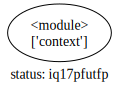

In [6]:
prompt = fastrepl.Updatable(
    key="context",
    value="You will get a input text from Yelp review. Take it seriously.",
)

fastrepl.graph()

In [7]:
def run_eval():
    print(f"Running..., prompt: {prompt.value}")
    eval = fastrepl.Evaluator(
        pipeline=[
            fastrepl.LLMChainOfThought(
                model="gpt-3.5-turbo",
                labels=labels,
                context=prompt.value,
            ),
            fastrepl.LLMClassifier(
                model="gpt-3.5-turbo",
                labels=labels,
            ),
        ]
    )
    return fastrepl.LocalRunner(evaluator=eval, dataset=dataset).run()

In [8]:
clear_output(wait=True)

result = run_eval()

predictions = [label_to_score(label) for label in result["prediction"]]
references = dataset["reference"]

print_metric("accuracy", predictions, references)
print_metric("mse", predictions, references)
print_metric("mae", predictions, references)

Output()

Running..., prompt: You will get a input text from Yelp review. Take it seriously.


accuracy: 0.6
mse: 0.4
mae: 0.4


In [9]:
clear_output(wait=True)

fastrepl.update(
    [
        (
            "context",
            "You will get a input text from somewhere. Make some jokes about it.",
        ),
    ]
)
result = run_eval()

predictions = [label_to_score(label) for label in result["prediction"]]
references = dataset["reference"]

print_metric("accuracy", predictions, references)
print_metric("mse", predictions, references)
print_metric("mae", predictions, references)

Output()

Running..., prompt: You will get a input text from somewhere. Make some jokes about it.


accuracy: 0.6
mse: 0.4
mae: 0.4
